<a href="https://colab.research.google.com/github/CepbluKot/ecology_ml/blob/main/ecology_ml_w_data_filter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1261]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


df = pd.read_csv('data.csv')
df=df.drop(['X','Y','ObjectID','code', 'area', 'ID', 'texture', 'parentrock', 'relief', 'soil_name', 'Al ммоль-экв/100г'], axis=1)
df.head(5)

,pHH20,pHKCl,Гумус %,P мг/кг,K мг/кг,Mn мг/кг,Co мг/кг,Cu мг/кг,Zn мг/кг,Mo мг/кг,B мг/кг,Ca ммоль-экв/100г,Mg ммоль-экв/100г,N_NH4 мг/кг,N_NO3 мг/кг,Z,NDVI
0,5.8,5.0,6.5,81.1,178.3,24.1,0.04,0.06,0.21,0.0,2.2,13.7,2.7,8.9,40.8,1.706668,0.727741
1,5.9,5.1,6.2,262.9,328.8,29.0,0.04,0.07,0.18,0.0,2.6,14.3,2.6,12.1,43.4,1.811376,0.658671
2,5.7,4.9,7.4,202.3,255.5,27.9,0.04,0.10,0.25,0.0,2.1,12.5,2.5,9.0,24.3,1.891337,0.768856
3,5.9,5.0,7.2,66.7,136.8,15.1,0.03,0.10,0.37,0.0,2.3,14.4,2.7,9.1,21.8,1.919135,0.722283
4,5.7,5.0,6.7,68.0,210.7,22.9,0.04,0.06,0.22,0.0,2.0,12.5,2.3,8.2,24.1,1.609458,0.700665


Для начала проведем очистку данных. 

Во-первых проверим, есть ли в данных пустые элементы (клетки в экселе).

На данном рисунке синим обозначается пустая клетка, желтым - заполненная.

<AxesSubplot: >

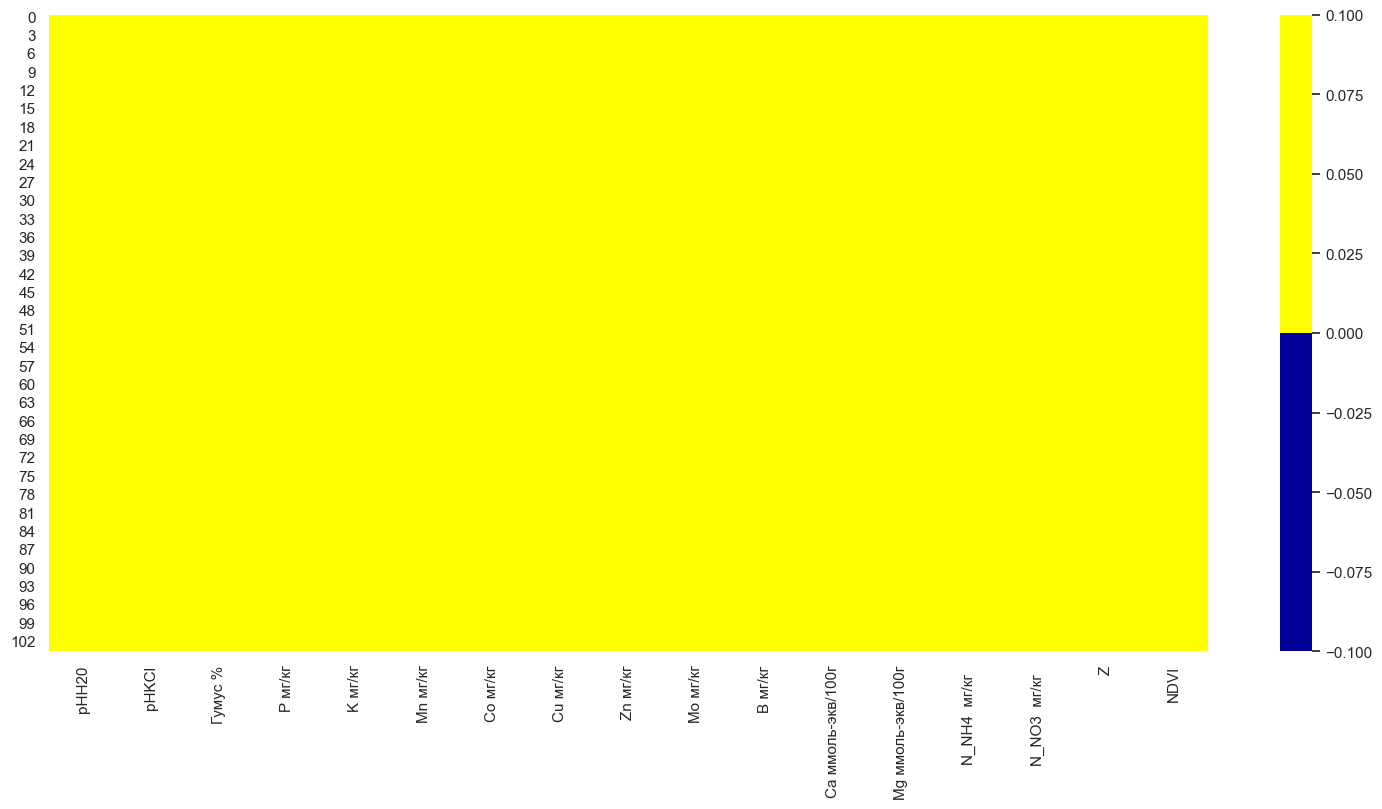

In [1262]:
colours = ['#000099', '#ffff00'] 
sns.heatmap(df.isnull(), cmap=sns.color_palette(colours))

Как мы видим пропусков в данных нет, можем приступать к следующему этапу.

Выполним очистку от повторяющихся данных.

In [1263]:
df = df.drop_duplicates()


print(df.shape)
print(df_dedupped.shape)

(104, 17)
(104, 17)


Следующим этапом выполним поиск и удаление выбросов - данных, которые аномально отклоняются от остальных и ухудшают точность модели. 

Ниже приведены графики распределения значений по параметрам жо и после очистки.

Для обнаружения выбросов применяется алгоритм Isolation Forest. 

In [1264]:
X=df.drop('NDVI',axis=1)
y=df['NDVI']

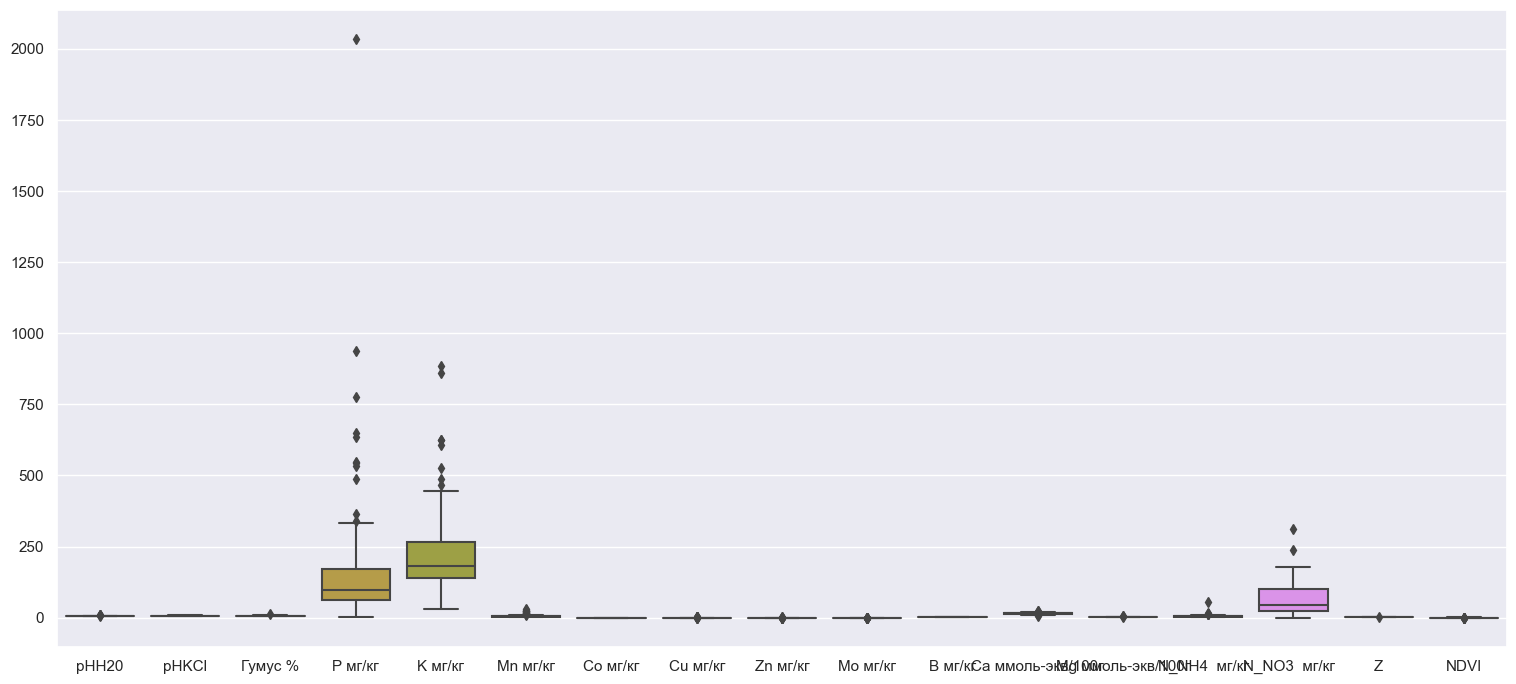

In [1265]:
import seaborn as sns


sns.set(rc={'figure.figsize':(18.7,8.27)})
ax = sns.boxplot(df)  

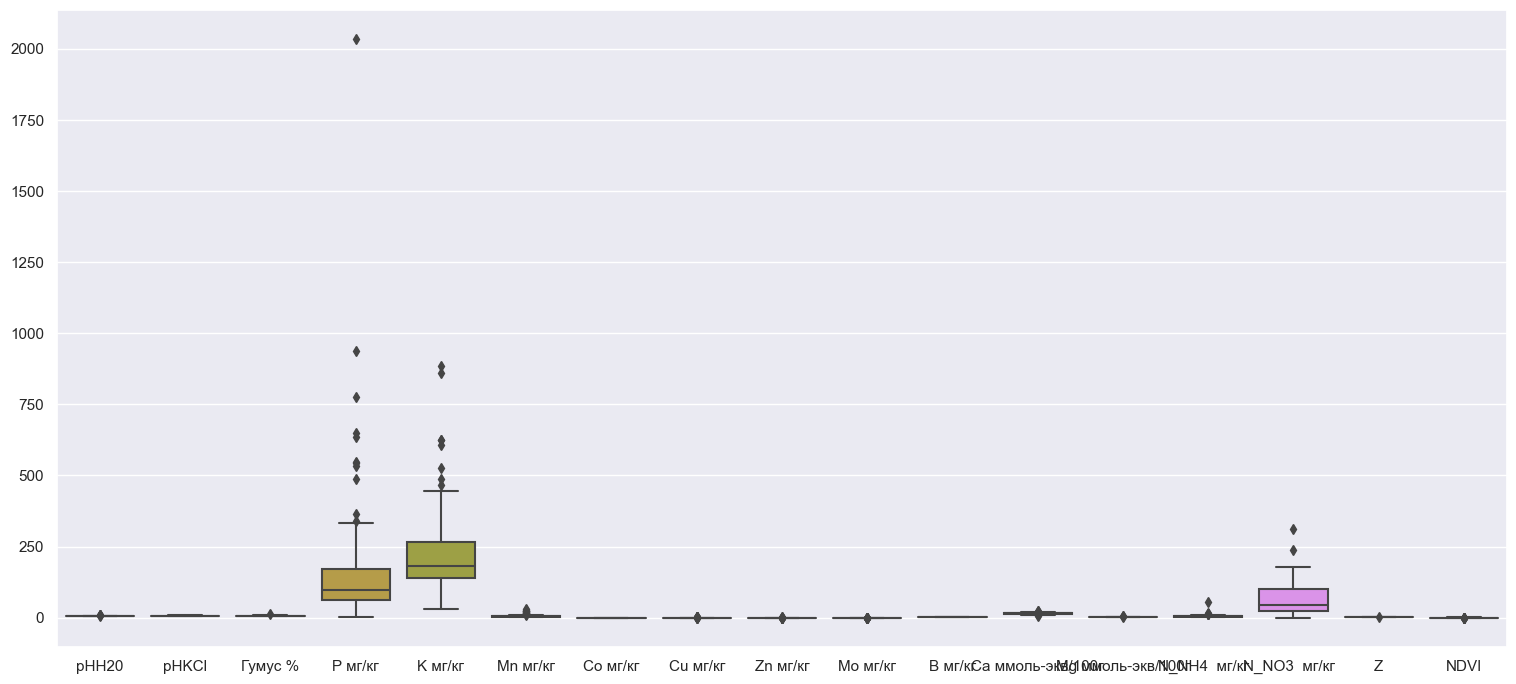

In [1266]:
from sklearn.datasets import load_diabetes
from sklearn.ensemble import IsolationForest


iso = IsolationForest()
y_outliers = iso.fit_predict(df)

for i in range(len(y_outliers)):
    if y_outliers[i] == -1:
        df.drop(i, inplace = False)

ax = sns.boxplot(df)  

Следующим этапом проверим зависимости между параметрами, для этого построим тепловую карту. 

Чем ближе значение к 1, тем сильнее зависимость.

Задача данного этапа - обнаружить параметры с сильной зависимостью от других и убрать эти параметры из набора данных. В противном случае точность модели ухудшиться.

<AxesSubplot: >

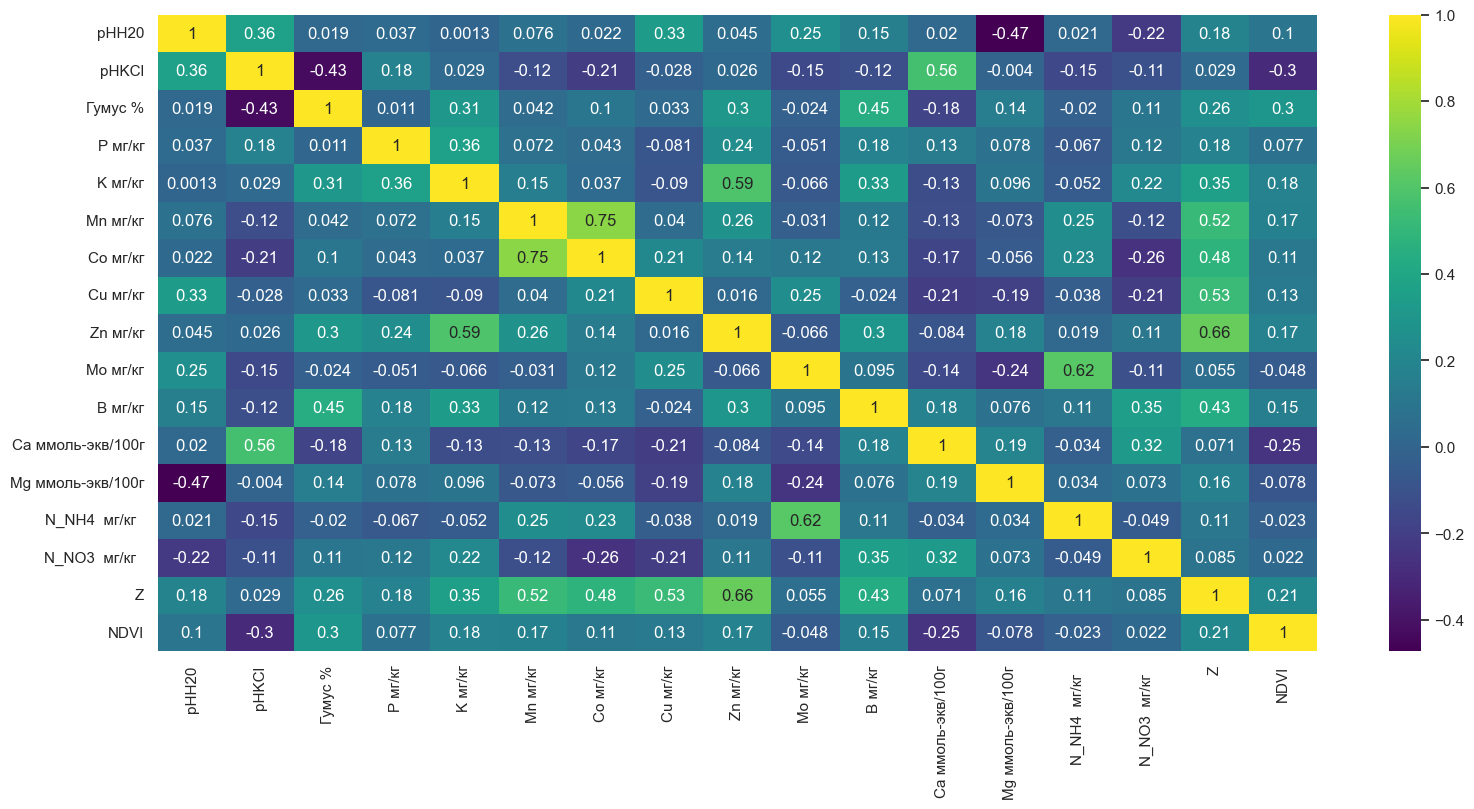

In [1267]:
sns.heatmap(df.corr(),  cmap = 'viridis',annot = True)

Как мы видим сильных зависимостей нет, поэтому удаление параметров не требуется.

Следующим этапом проскалируем данные, т.е преобразуем значения таким образом, чтобы любое из них лежало в промежутке от 0 до 1. 

Это нужно для повышения качества модели.

In [1268]:
from sklearn.preprocessing import MinMaxScaler


scaler = MinMaxScaler()
X_norm = scaler.fit_transform(X)

Далее нам нужно из всех параметров датасета выделить самые эффективные, т.е те, по которым в наибольшей степени видна разница между данными.

Для решения этой задачи воспользуемся несколькими алгоритмами для того, чтобы в дальнейшем на самой модели проверить качество работы каждого из них.

Используем след. алгоритмы: Random Forest, SelectKBest, Recursive feature elimination (RFE) 

То, сколько параметров каждый алгоритм сгенерирует, задается вручную.

При помощи каждого алгоритма сгенерируем массив с наборами выбранными параметрами для дальнейшей проверки на моделях и выбора лучшего. Размерность набора варьируется от 5 до 16 параметров. 



In [1269]:
num_of_features_to_select_start = 5
num_of_features_to_select_end = len(df.columns)

select_k_best_features_test = []
random_forest_features_test = []
rfe_features_test = []

In [1270]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression


for num_of_features_to_select in range(num_of_features_to_select_start, num_of_features_to_select_end):

  best_parameters_selector = SelectKBest(score_func=f_regression, k=num_of_features_to_select)

  selected_parameters_data = best_parameters_selector.fit_transform(X_norm, y)

  filter = best_parameters_selector.get_support()
  features = X.columns

  select_k_best_features = features[filter]

  select_k_best_features_test.append(select_k_best_features)

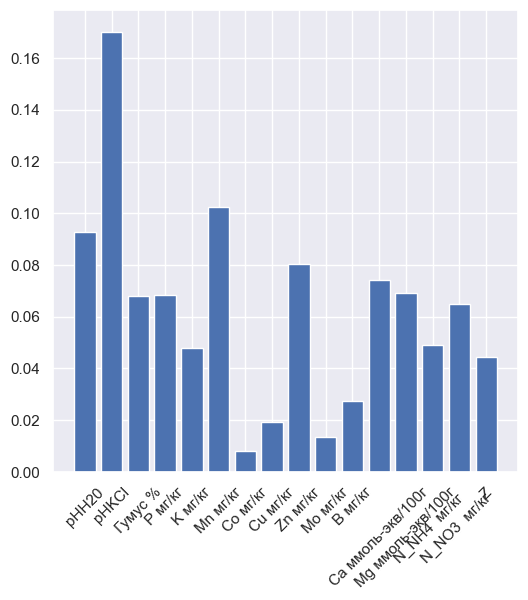

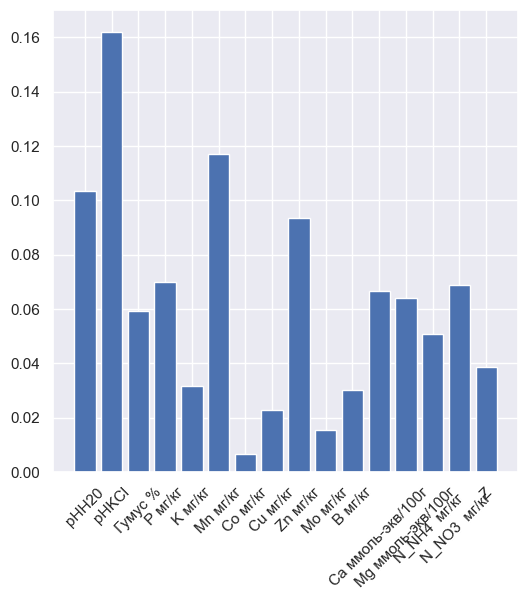

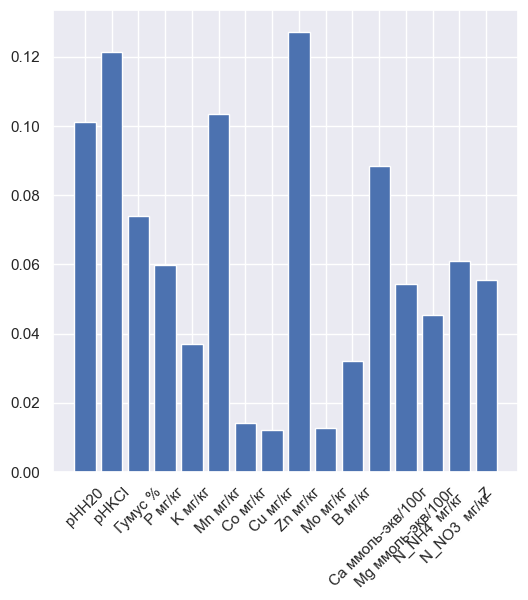

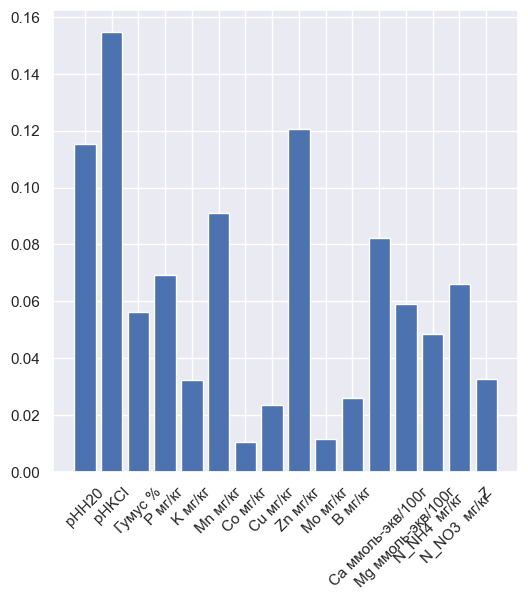

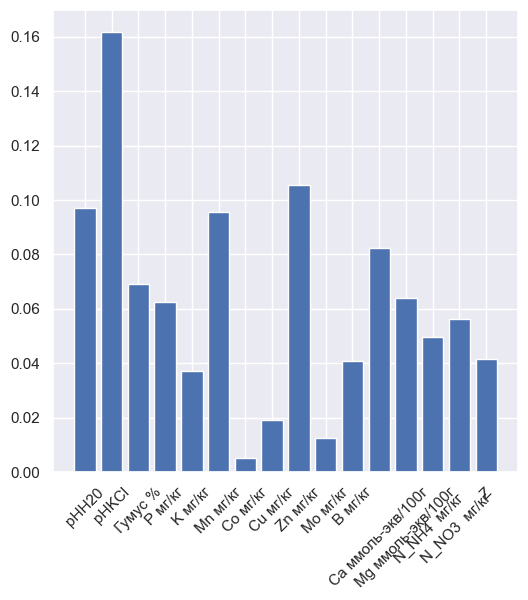

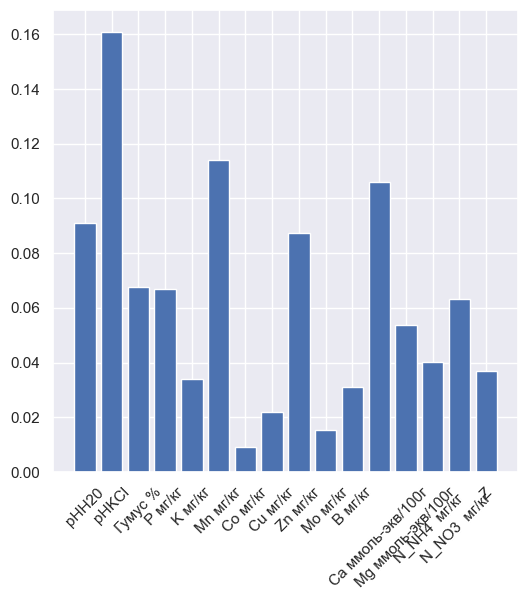

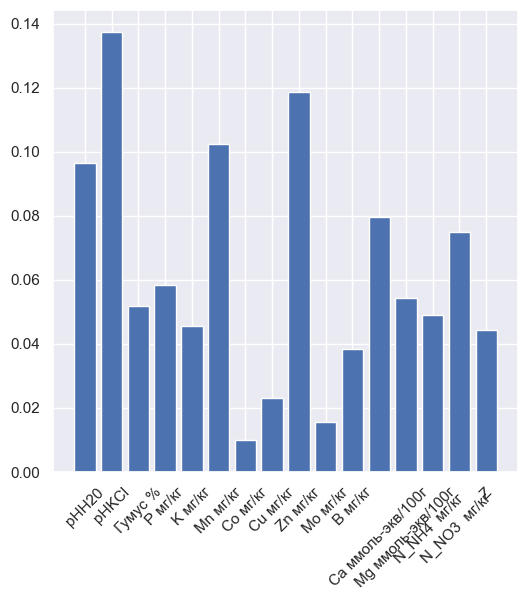

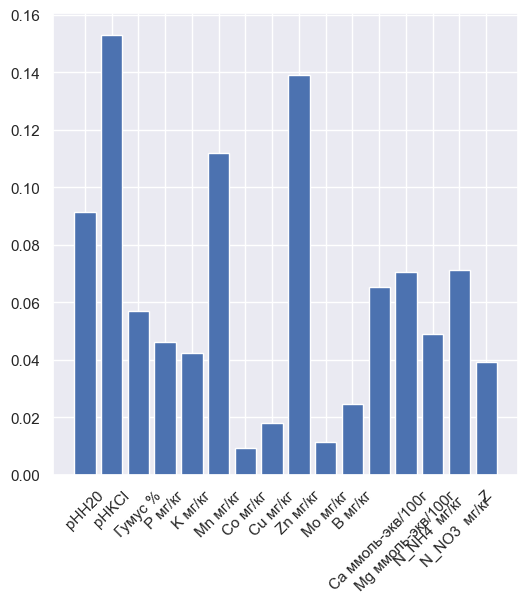

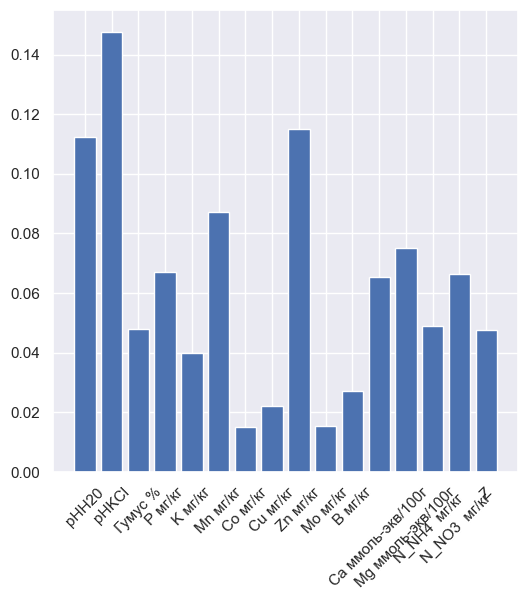

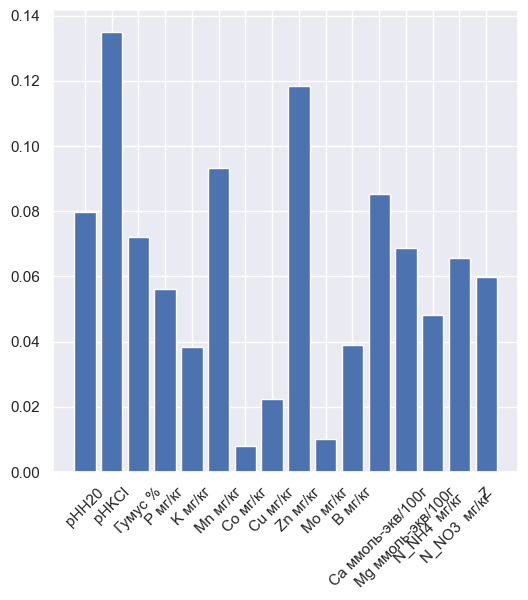

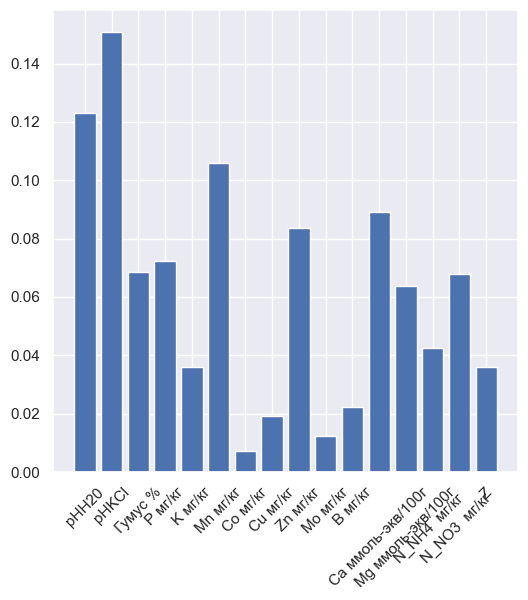

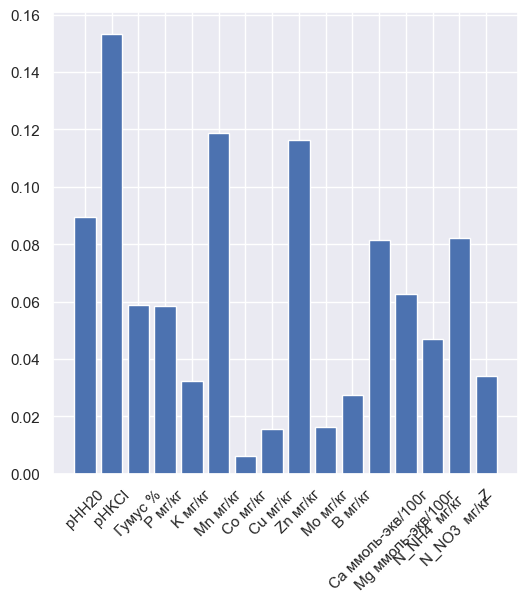

In [1271]:
from sklearn.ensemble import RandomForestRegressor


for num_of_features_to_select in range(num_of_features_to_select_start, num_of_features_to_select_end):
  regr = RandomForestRegressor()
  regr.fit(X_norm, y)

  random_forest_features = {}
  for id in range(len(X.columns)):
    random_forest_features[X.columns[id]] = regr.feature_importances_[id]


  random_forest_features = dict(sorted(random_forest_features.items(), key=lambda item: item[1], reverse=True)[:num_of_features_to_select]).keys()

  random_forest_features_test.append(random_forest_features)

In [1272]:
from sklearn.feature_selection import RFE

for num_of_features_to_select in range(num_of_features_to_select_start, num_of_features_to_select_end):
  rfe = RFE(estimator=RandomForestRegressor(), n_features_to_select=num_of_features_to_select)
  rfe_res = rfe.fit_transform(X_norm, y)


  filter = rfe.get_support()
  features = X.columns


  rfe_features = features.values[filter]
  rfe_features_test.append(rfe_features)

Массивы с выбранными наборами параметров для каждого алгоритма получены, этап очистки данных завершен.

Далее выберем несколько алгоритмов модели и протестируем качество работы каждого на полученных наборах параметров.




Используем след. алгоритмы:
Linear Regression

KNeighborsRegressor

RandomForestRegressor

ExtraTreesRegressor




При проверке работы алгоритма модели выполняются след. действия:

1) берем данные из датасета по выбранному набору параметров

2) Делим данные на наборы для обучения и тестирования (по объему: для обучения - 80% от исходного, для тестирования - 20%)

3) обучаем модель на данных для обучения

4) проводим проверку c помощью коэфициента детерминации, чем выше его значение - тем лучше.

Для приемлемых моделей предполагается, что коэффициент детерминации должен быть хотя бы не меньше 0.5.

In [1273]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

In [1274]:
X=df.drop('NDVI',axis=1)
Y=df['NDVI']
X_train, X_test, Y_train, Y_test  = train_test_split(X, Y, test_size = 0.20, shuffle = True)

Ниже приведены 3 теста алгоритма Linear Regression. 

На каждом графике по оси X - число выделенных параметров, Y - оценка работы модели.

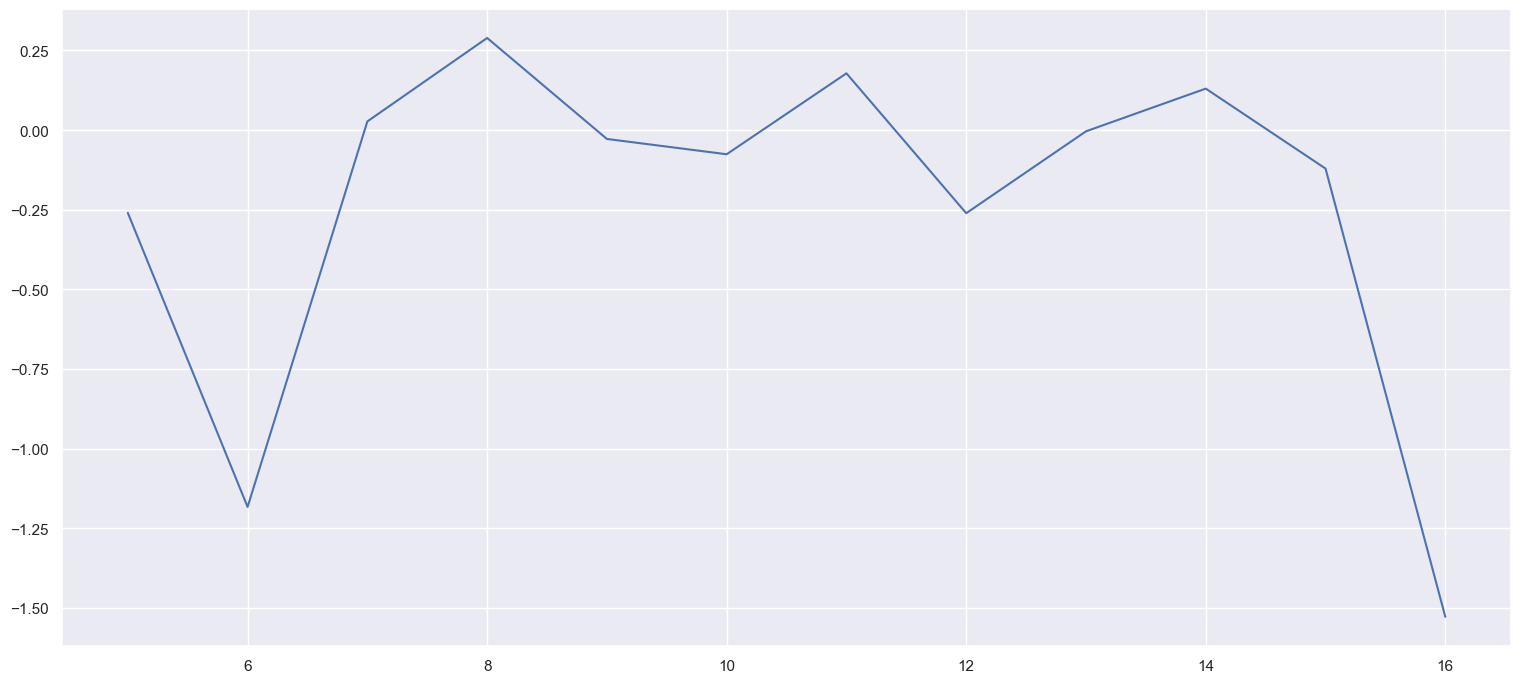

In [1276]:
error_results = []
num_of_selected_vals = []

for select_k_best_features in select_k_best_features_test:
  X=df.drop('NDVI',axis=1)
  X=df[select_k_best_features]
  Y=df['NDVI']


  X_train, X_test, Y_train, Y_test  = train_test_split(X, Y, test_size = 0.20, shuffle = True)

  LR = LinearRegression()
  LR.fit(X_train, Y_train)				#Обучаем модель
  Y_LR = LR.predict(X_test)				#Предсказываем значения для выборки    

  # print('fakescore', LR.score(X_train, Y_train))


  # print ('MAE:', round (mean_absolute_error(Y_test, Y_LR),3))		#Метрики
  # print ('√MSE:', round (mean_squared_error(Y_test, Y_LR)**(1/2),3))
  print (f'R2_score for {len(select_k_best_features)}:', round (r2_score(Y_test, Y_LR),3))
  error_results.append(round (r2_score(Y_test, Y_LR),3))
  num_of_selected_vals.append(len(select_k_best_features))


plt.plot(num_of_selected_vals, error_results, )

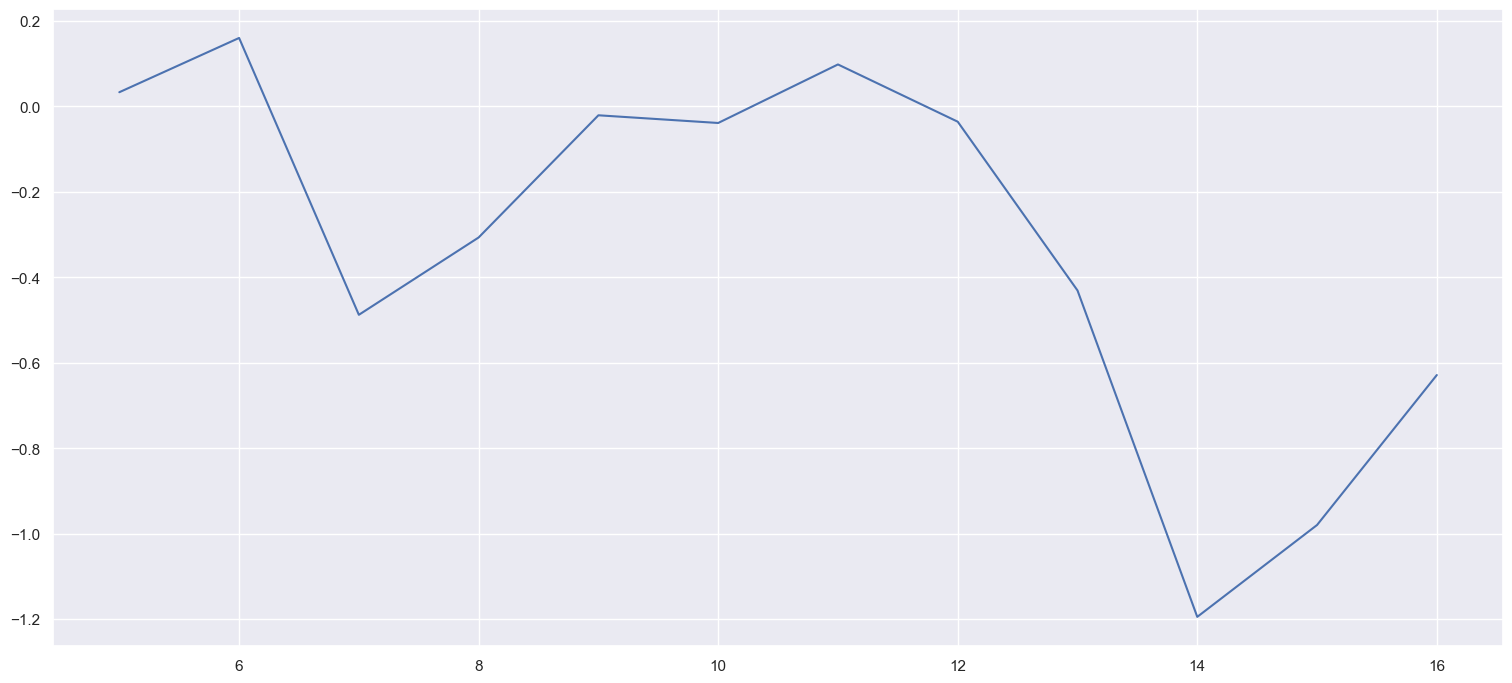

In [1277]:
error_results = []
num_of_selected_vals = []


for random_forest_features in random_forest_features_test:
  X=df.drop('NDVI',axis=1)
  X=df[random_forest_features]
  Y=df['NDVI']


  X_train, X_test, Y_train, Y_test  = train_test_split(X, Y, test_size = 0.20, shuffle = True)

  LR = LinearRegression()
  LR.fit(X_train, Y_train)				#Обучаем модель
  Y_LR = LR.predict(X_test)				#Предсказываем значения для выборки    

  # print('fakescore', LR.score(X_train, Y_train))


  # print ('MAE:', round (mean_absolute_error(Y_test, Y_LR),3))		#Метрики
  # print ('√MSE:', round (mean_squared_error(Y_test, Y_LR)**(1/2),3))
  # print (f'R2_score for {len(random_forest_features)}:', round (r2_score(Y_test, Y_LR),3))
  error_results.append(round (r2_score(Y_test, Y_LR),3))
  num_of_selected_vals.append(len(random_forest_features))

plt.plot(num_of_selected_vals, error_results, )

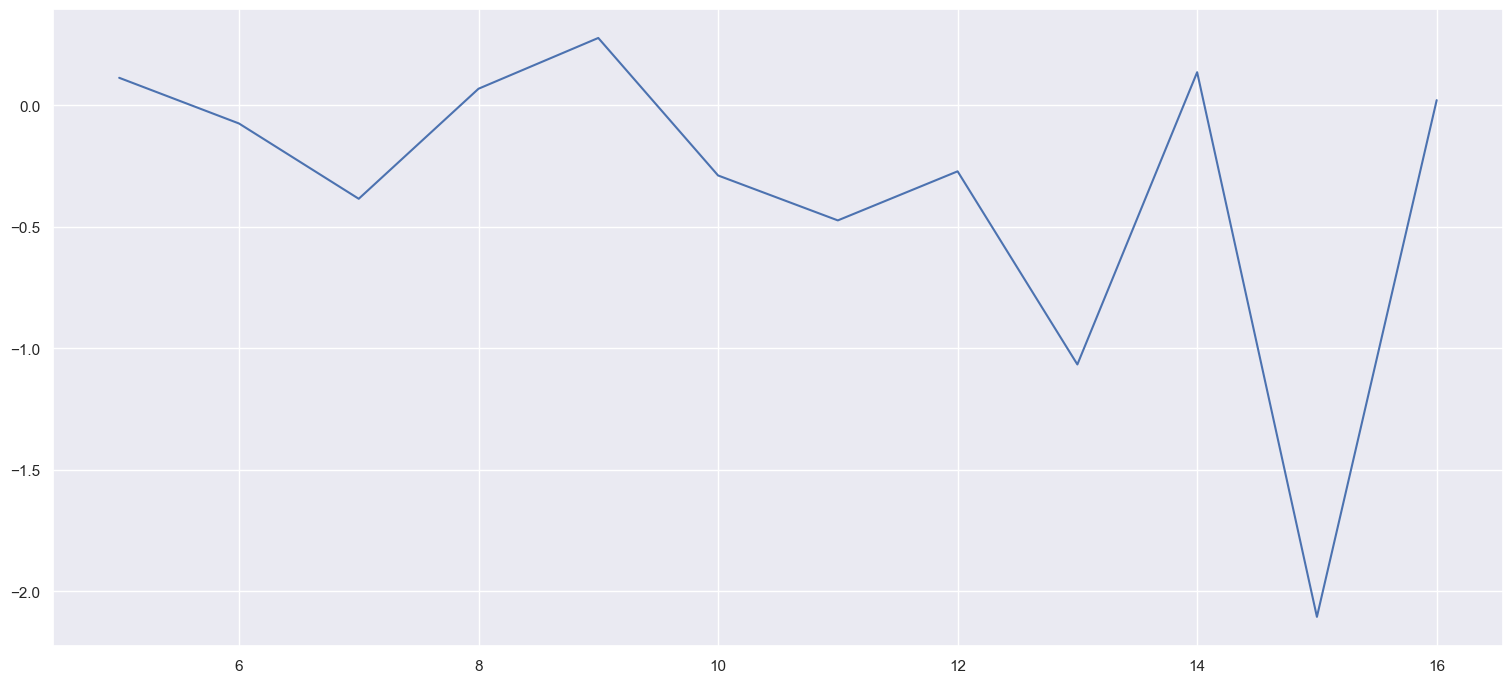

In [1278]:
error_results = []
num_of_selected_vals = []


for rfe_features in rfe_features_test:
  X=df.drop('NDVI',axis=1)
  X=df[rfe_features]
  Y=df['NDVI']


  X_train, X_test, Y_train, Y_test  = train_test_split(X, Y, test_size = 0.20, shuffle = True)

  LR = LinearRegression()
  LR.fit(X_train, Y_train)				#Обучаем модель
  Y_LR = LR.predict(X_test)				#Предсказываем значения для выборки    

  # print('fakescore', LR.score(X_train, Y_train))


  # print ('MAE:', round (mean_absolute_error(Y_test, Y_LR),3))		#Метрики
  # print ('√MSE:', round (mean_squared_error(Y_test, Y_LR)**(1/2),3))
  # print (f'R2_score for {len(rfe_features)}: ', round (r2_score(Y_test, Y_LR),3))

  error_results.append(round (r2_score(Y_test, Y_LR),3))
  num_of_selected_vals.append(len(rfe_features))


plt.plot(num_of_selected_vals, error_results, )

In [1279]:
final_selected_features = random_forest_features_test[3]
print(len(final_selected_features))

8


Ниже приведены 3 теста алгоритма KNeighborsRegressor. 

На каждом графике по оси X - число выделенных параметров, Y - оценка работы модели.

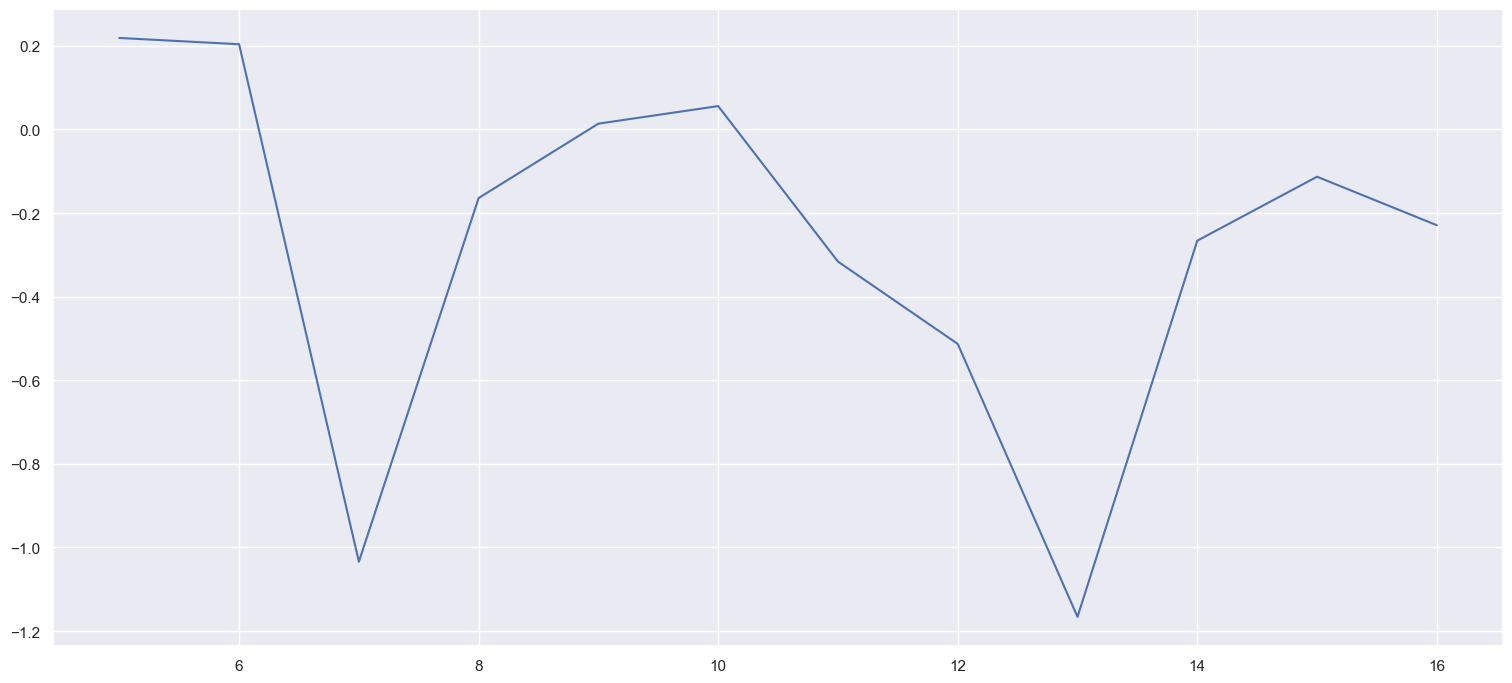

In [1280]:
from sklearn.neighbors import KNeighborsRegressor


error_results = []
num_of_selected_vals = []


for random_forest_features in random_forest_features_test:
  X=df.drop('NDVI',axis=1)
  X=df[random_forest_features]
  Y=df['NDVI']


  X_train, X_test, Y_train, Y_test  = train_test_split(X, Y, test_size = 0.20, shuffle = True)

  LR = KNeighborsRegressor()
  LR.fit(X_train, Y_train)				#Обучаем модель
  Y_LR = LR.predict(X_test)				#Предсказываем значения для выборки    

  # print('fakescore', LR.score(X_train, Y_train))


  # print ('MAE:', round (mean_absolute_error(Y_test, Y_LR),3))		#Метрики
  # print ('√MSE:', round (mean_squared_error(Y_test, Y_LR)**(1/2),3))
  # print (f'R2_score for {len(rfe_features)}: ', round (r2_score(Y_test, Y_LR),3))


  error_results.append(round (r2_score(Y_test, Y_LR),3))
  num_of_selected_vals.append(len(random_forest_features))


plt.plot(num_of_selected_vals, error_results, )

Ниже приведены 3 теста алгоритма RandomForestRegressor. 

На каждом графике по оси X - число выделенных параметров, Y - оценка работы модели.

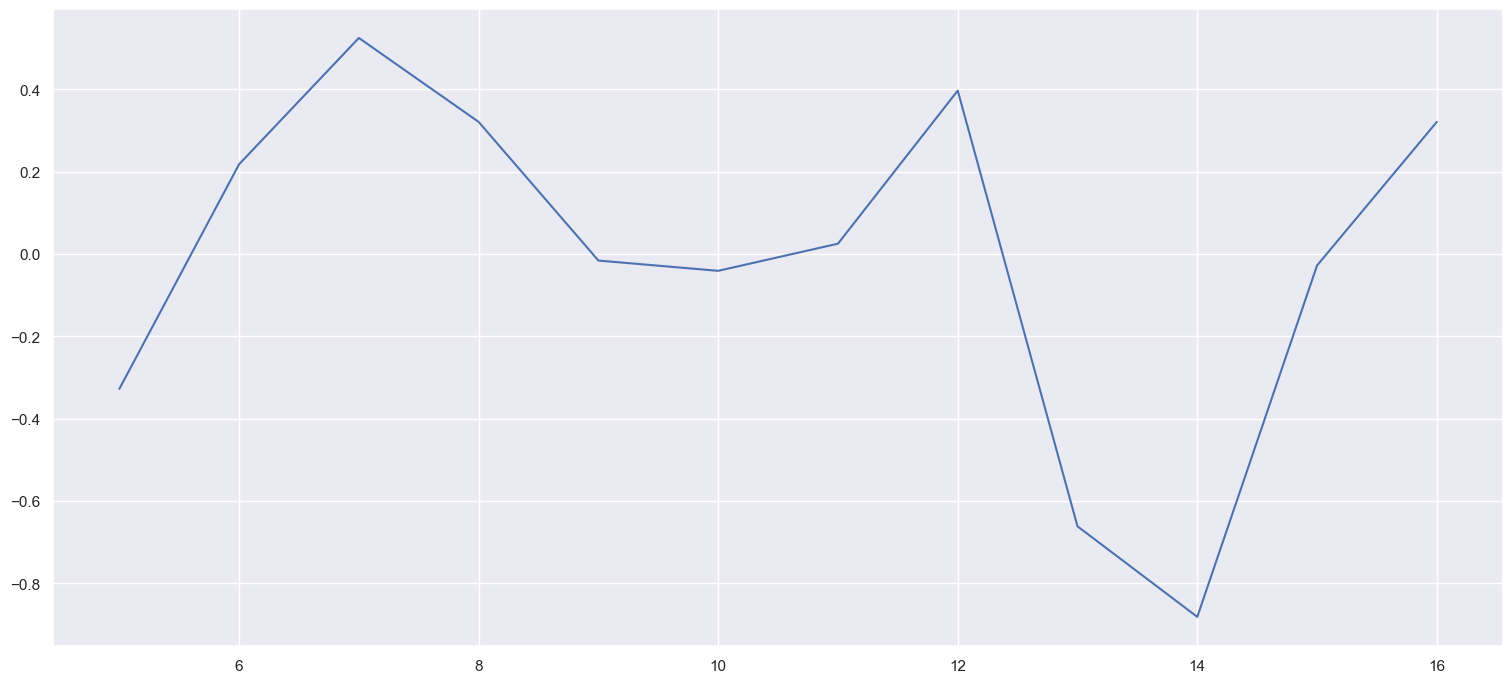

In [1281]:
from sklearn.ensemble import RandomForestRegressor


error_results = []
num_of_selected_vals = []


for random_forest_features in random_forest_features_test:
  X=df.drop('NDVI',axis=1)
  X=df[random_forest_features]
  Y=df['NDVI']


  X_train, X_test, Y_train, Y_test  = train_test_split(X, Y, test_size = 0.20, shuffle = True)

  LR = RandomForestRegressor()
  LR.fit(X_train, Y_train)				#Обучаем модель
  Y_LR = LR.predict(X_test)				#Предсказываем значения для выборки    

  # print('fakescore', LR.score(X_train, Y_train))


  # print ('MAE:', round (mean_absolute_error(Y_test, Y_LR),3))		#Метрики
  # print ('√MSE:', round (mean_squared_error(Y_test, Y_LR)**(1/2),3))
  # print (f'R2_score for {len(rfe_features)}: ', round (r2_score(Y_test, Y_LR),3))

  error_results.append(round (r2_score(Y_test, Y_LR),3))
  num_of_selected_vals.append(len(random_forest_features))


plt.plot(num_of_selected_vals, error_results, )

Ниже приведены 3 теста алгоритма ExtraTreesRegressor. 

На каждом графике по оси X - число выделенных параметров, Y - оценка работы модели.

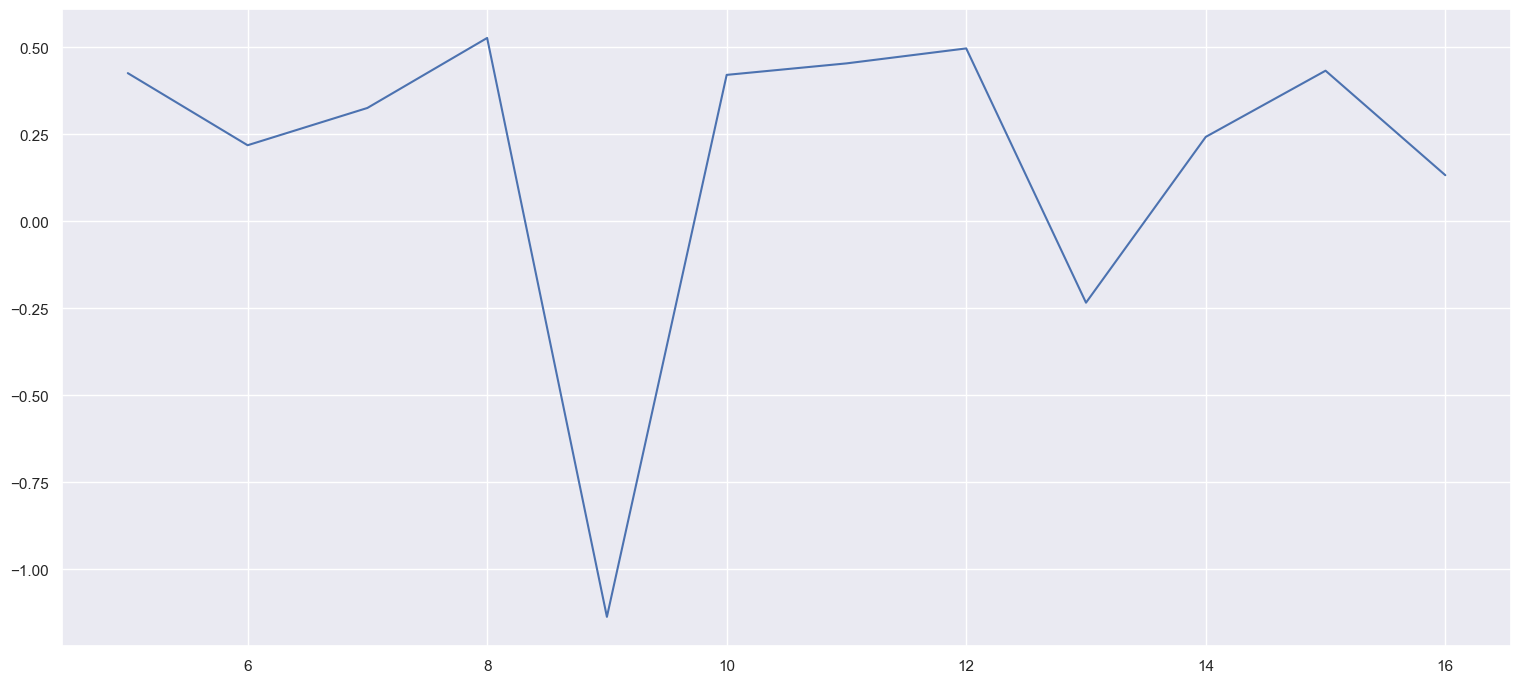

In [1282]:
# best method

from sklearn.ensemble import ExtraTreesRegressor


error_results = []
num_of_selected_vals = []


for random_forest_features in random_forest_features_test:
  X=df.drop('NDVI',axis=1)
  X=df[random_forest_features]
  Y=df['NDVI']


  X_train, X_test, Y_train, Y_test  = train_test_split(X, Y, test_size = 0.20, shuffle = True)

  LR = ExtraTreesRegressor()
  LR.fit(X_train, Y_train)				#Обучаем модель
  Y_LR = LR.predict(X_test)				#Предсказываем значения для выборки    

  # print('fakescore', LR.score(X_train, Y_train))


  # print ('MAE:', round (mean_absolute_error(Y_test, Y_LR),3))		#Метрики
  # print ('√MSE:', round (mean_squared_error(Y_test, Y_LR)**(1/2),3))
  # print (f'R2_score for {len(rfe_features)}: ', round (r2_score(Y_test, Y_LR),3))

  error_results.append(round (r2_score(Y_test, Y_LR),3))
  num_of_selected_vals.append(len(random_forest_features))


plt.plot(num_of_selected_vals, error_results, )

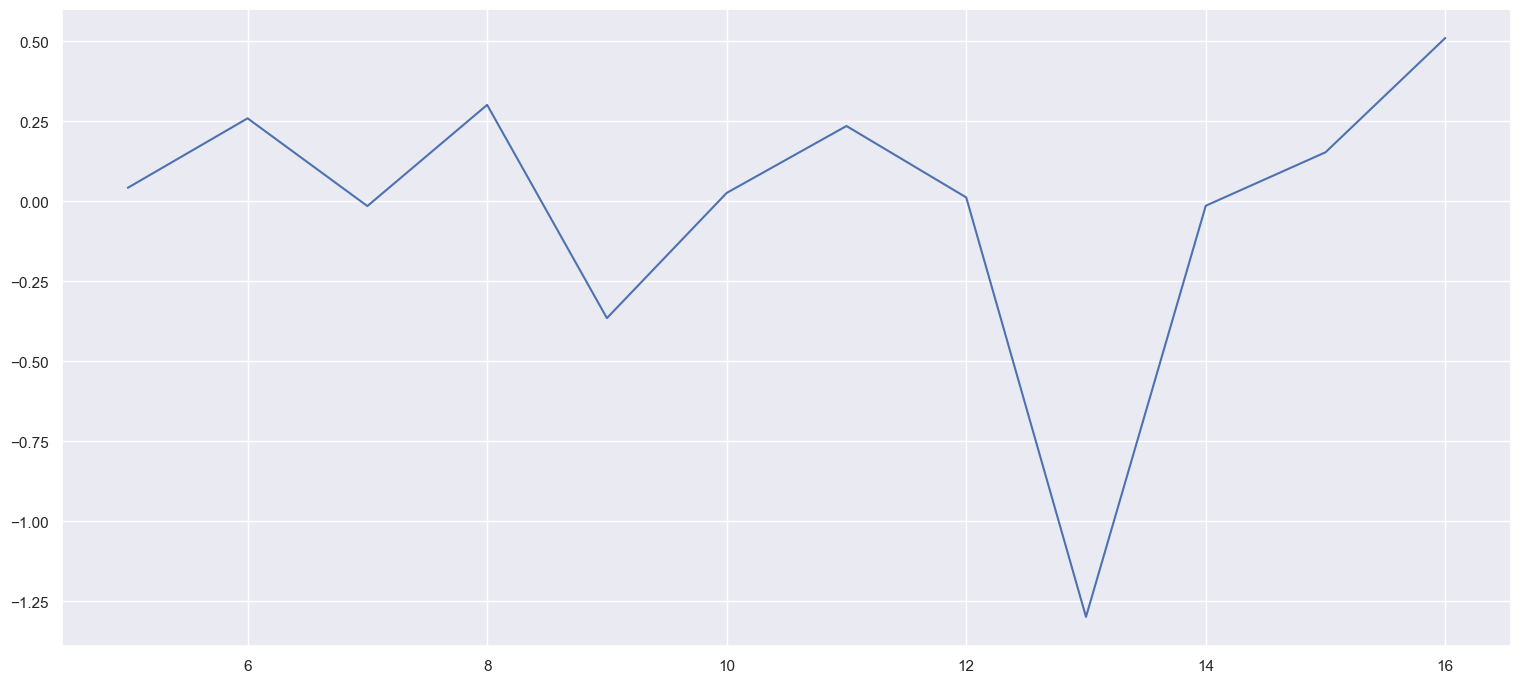

In [1283]:
from sklearn.ensemble import ExtraTreesRegressor


error_results = []
num_of_selected_vals = []


for random_forest_features in rfe_features_test:
  X=df.drop('NDVI',axis=1)
  X=df[random_forest_features]
  Y=df['NDVI']


  X_train, X_test, Y_train, Y_test  = train_test_split(X, Y, test_size = 0.20, shuffle = True)

  LR = ExtraTreesRegressor()
  LR.fit(X_train, Y_train)				#Обучаем модель
  Y_LR = LR.predict(X_test)				#Предсказываем значения для выборки    

  # print('fakescore', LR.score(X_train, Y_train))


  # print ('MAE:', round (mean_absolute_error(Y_test, Y_LR),3))		#Метрики
  # print ('√MSE:', round (mean_squared_error(Y_test, Y_LR)**(1/2),3))
  # print (f'R2_score for {len(rfe_features)}: ', round (r2_score(Y_test, Y_LR),3))

  error_results.append(round (r2_score(Y_test, Y_LR),3))
  num_of_selected_vals.append(len(random_forest_features))


plt.plot(num_of_selected_vals, error_results, )

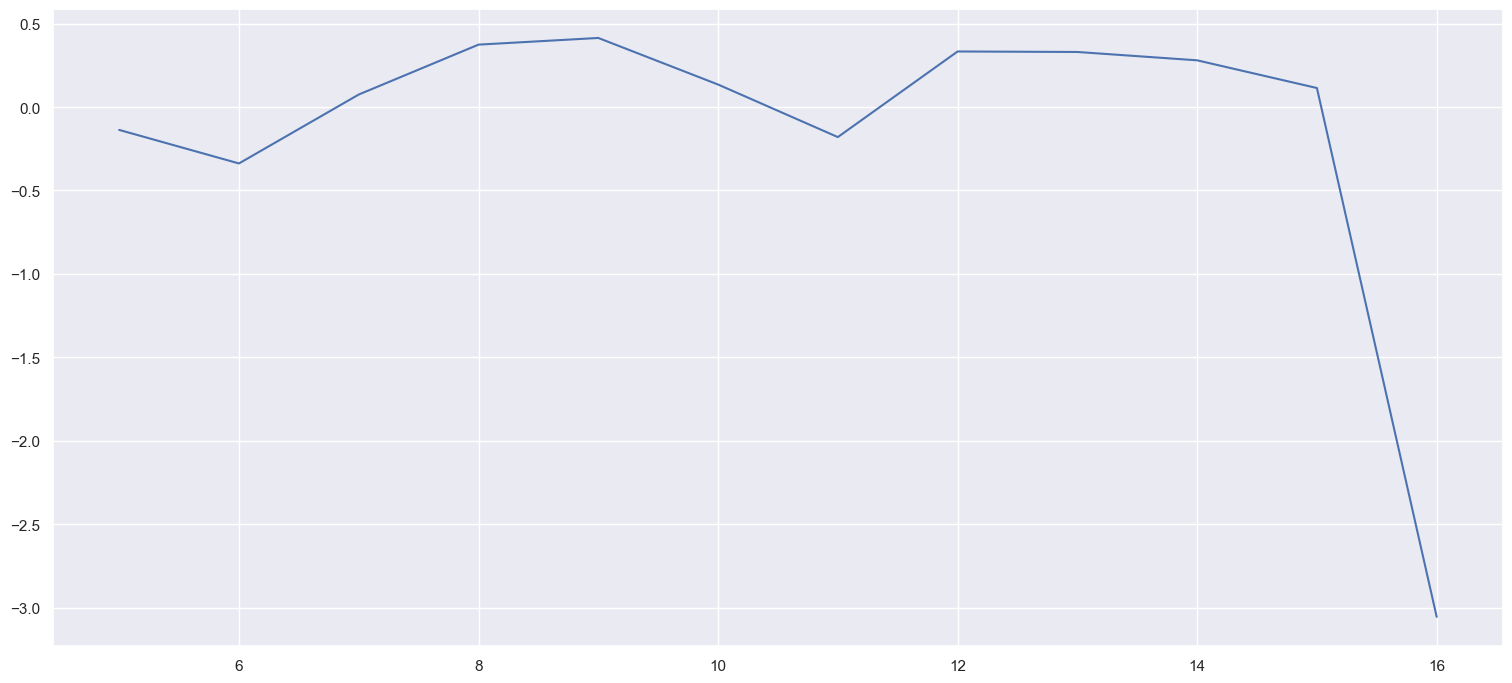

In [1284]:
from sklearn.ensemble import ExtraTreesRegressor


error_results = []
num_of_selected_vals = []


for random_forest_features in select_k_best_features_test:
  X=df.drop('NDVI',axis=1)
  X=df[random_forest_features]
  Y=df['NDVI']


  X_train, X_test, Y_train, Y_test  = train_test_split(X, Y, test_size = 0.20, shuffle = True)

  LR = ExtraTreesRegressor()
  LR.fit(X_train, Y_train)				#Обучаем модель
  Y_LR = LR.predict(X_test)				#Предсказываем значения для выборки    

  # print('fakescore', LR.score(X_train, Y_train))


  # print ('MAE:', round (mean_absolute_error(Y_test, Y_LR),3))		#Метрики
  # print ('√MSE:', round (mean_squared_error(Y_test, Y_LR)**(1/2),3))
  # print (f'R2_score for {len(rfe_features)}: ', round (r2_score(Y_test, Y_LR),3))

  error_results.append(round (r2_score(Y_test, Y_LR),3))
  num_of_selected_vals.append(len(random_forest_features))


plt.plot(num_of_selected_vals, error_results, )

In [1291]:
optimal_features = random_forest_features_test[3]

print(random_forest_features_test[3])

dict_keys(['pHKCl', 'Zn мг/кг', 'pHH20', 'Mn мг/кг', 'Ca ммоль-экв/100г', 'P мг/кг', 'N_NO3  мг/кг  ', 'Mg ммоль-экв/100г'])


В результате проверки алгоритмов видно, что наилучшей точностью обладает алгоритм ExtraTreesRegressor. Наилучший набор параметров - 8 параметров сгенерированных алгоритмом RandomForestRegressor.

('pHKCl', 'Zn мг/кг', 'pHH20', 'Mn мг/кг', 'Ca ммоль-экв/100г', 'P мг/кг', 'N_NO3  мг/кг  ', 'Mg ммоль-экв/100г')

На основе этих параметров и алгоритма создадим модель и протестируем ее нанашем датасете.

In [1286]:
X=df[optimal_features]
Y=df['NDVI']


X_train, X_test, Y_train, Y_test  = train_test_split(X, Y, test_size = 0.20, shuffle = True)

LR = ExtraTreesRegressor()
LR.fit(X_train, Y_train)				#Обучаем модель
Y_LR = LR.predict(X_test)				#Предсказываем значения для выборки    

# print('fakescore', LR.score(X_train, Y_train))


# print ('MAE:', round (mean_absolute_error(Y_test, Y_LR),3))		#Метрики
# print ('√MSE:', round (mean_squared_error(Y_test, Y_LR)**(1/2),3))
print (f'R2_score for {len(rfe_features)}: ', round (r2_score(Y_test, Y_LR),3))

R2_score for 16:  0.263


Сгенерируем график истиных значений и значений, предугаданных моделью.

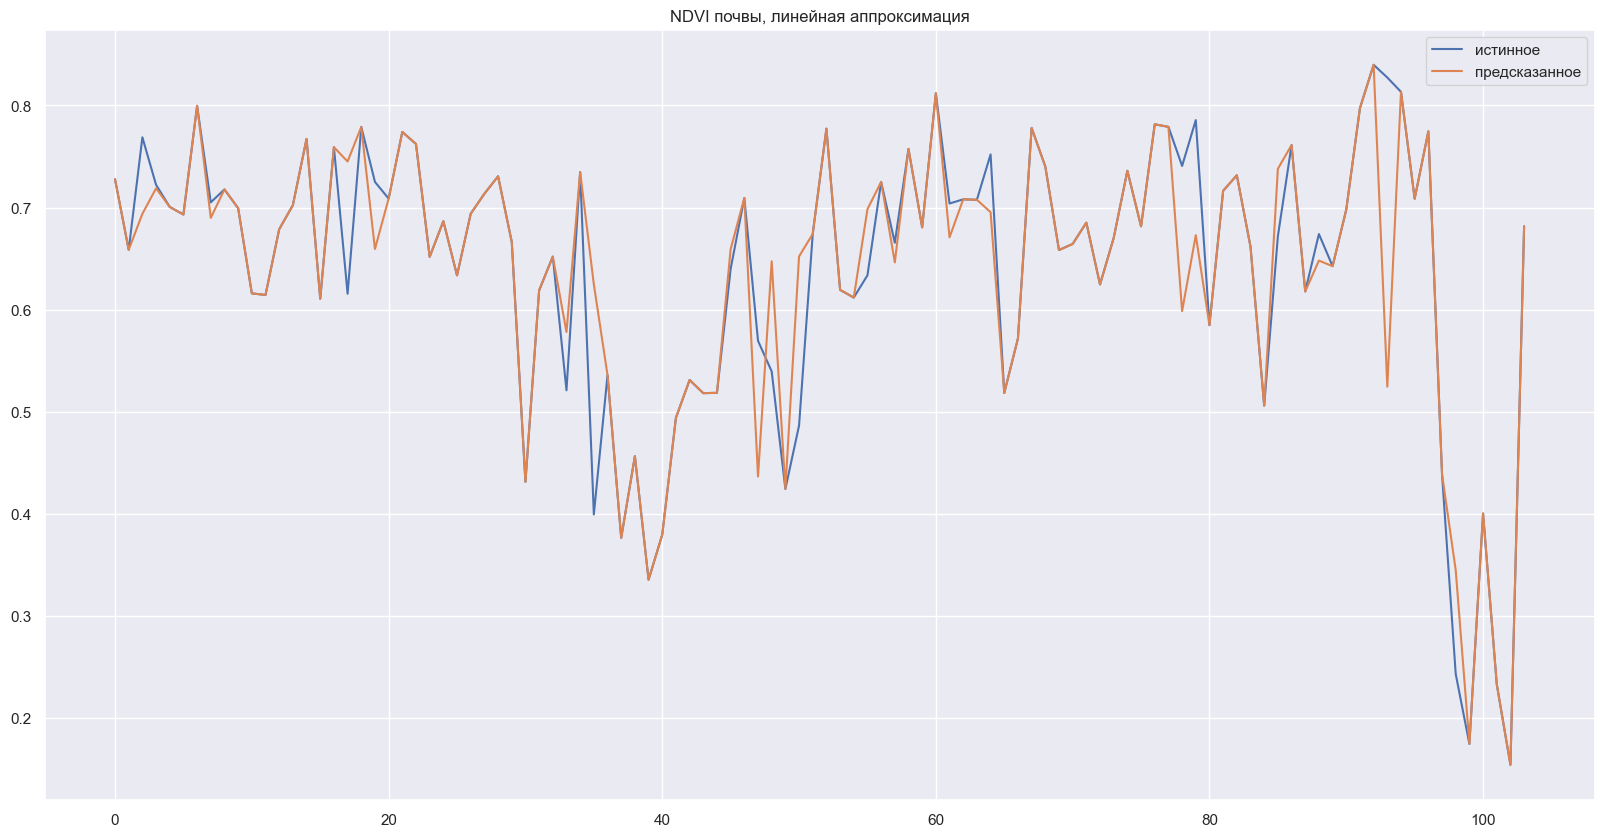

In [1287]:
predicted_NDVI = LR.predict(X)
real_NDVI = df['NDVI']

fig = plt.figure()
fig.set_figwidth(20)
fig.set_figheight(10)
plt.title("NDVI почвы, линейная аппроксимация")

plt.plot(real_NDVI, label="истинное")
plt.plot(predicted_NDVI, label="предсказанное")

plt.legend()
plt.show()

Как видно из графиков, наша модель обладает какой то точностью, однако ее можно усовершенствовать. 

Для этого можно найти ошибки между предугаданными и исходными данными, взять исходные данные с ошибкой меньше некоторого параметра error, на основе этих данных обучить нашу модель и протестировать еще раз.    

Для удобвтва выбора параметра error сгенерируем график зависимости размеров ошибок и индексов наборов данных.

0.717805803


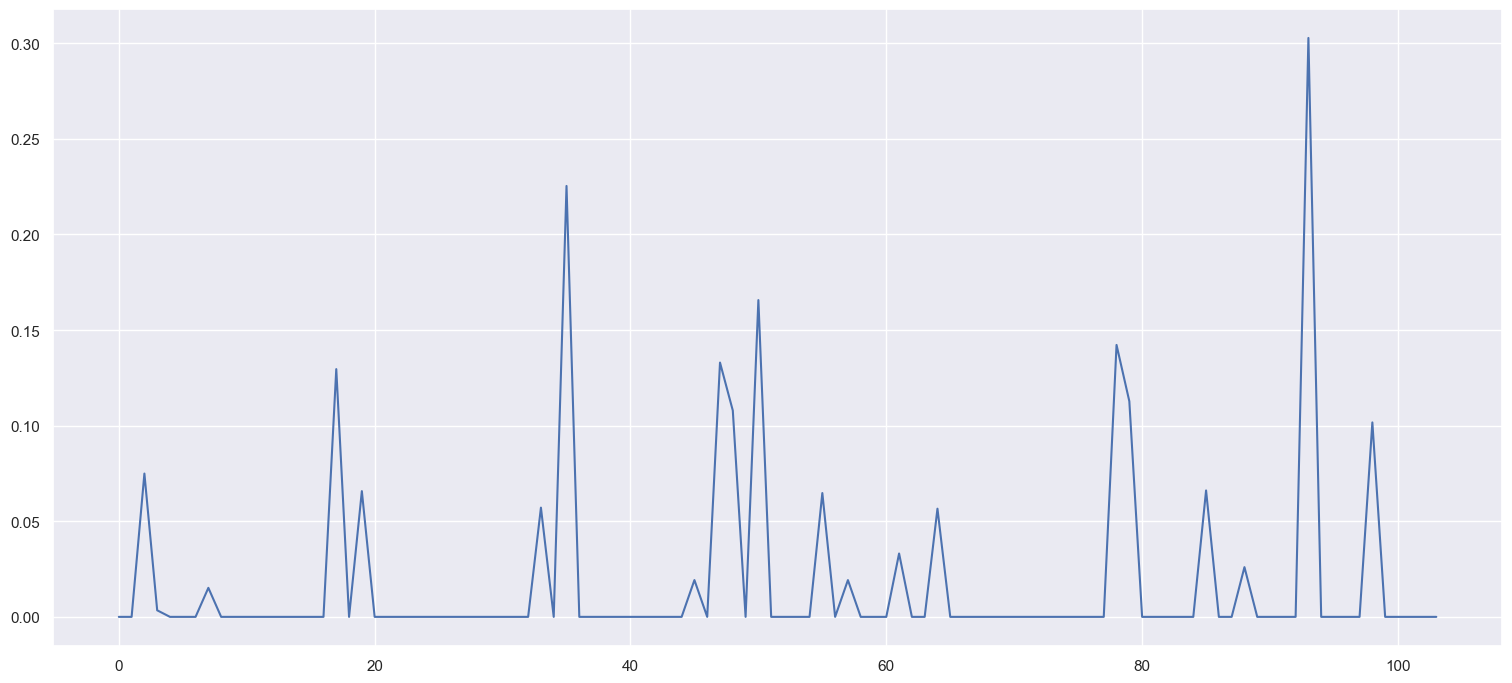

In [1288]:
eror_list = []
print(real_NDVI[8])
for x in range(0, len(real_NDVI)):
    eror = abs(real_NDVI[x] - predicted_NDVI[x])
    eror_list.append(eror)

plt.plot(eror_list)

C:\Users\aweso\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:402: UserWarning: X has feature names, but ExtraTreesRegressor was fitted without feature names
  warnings.warn(


R2 1.0


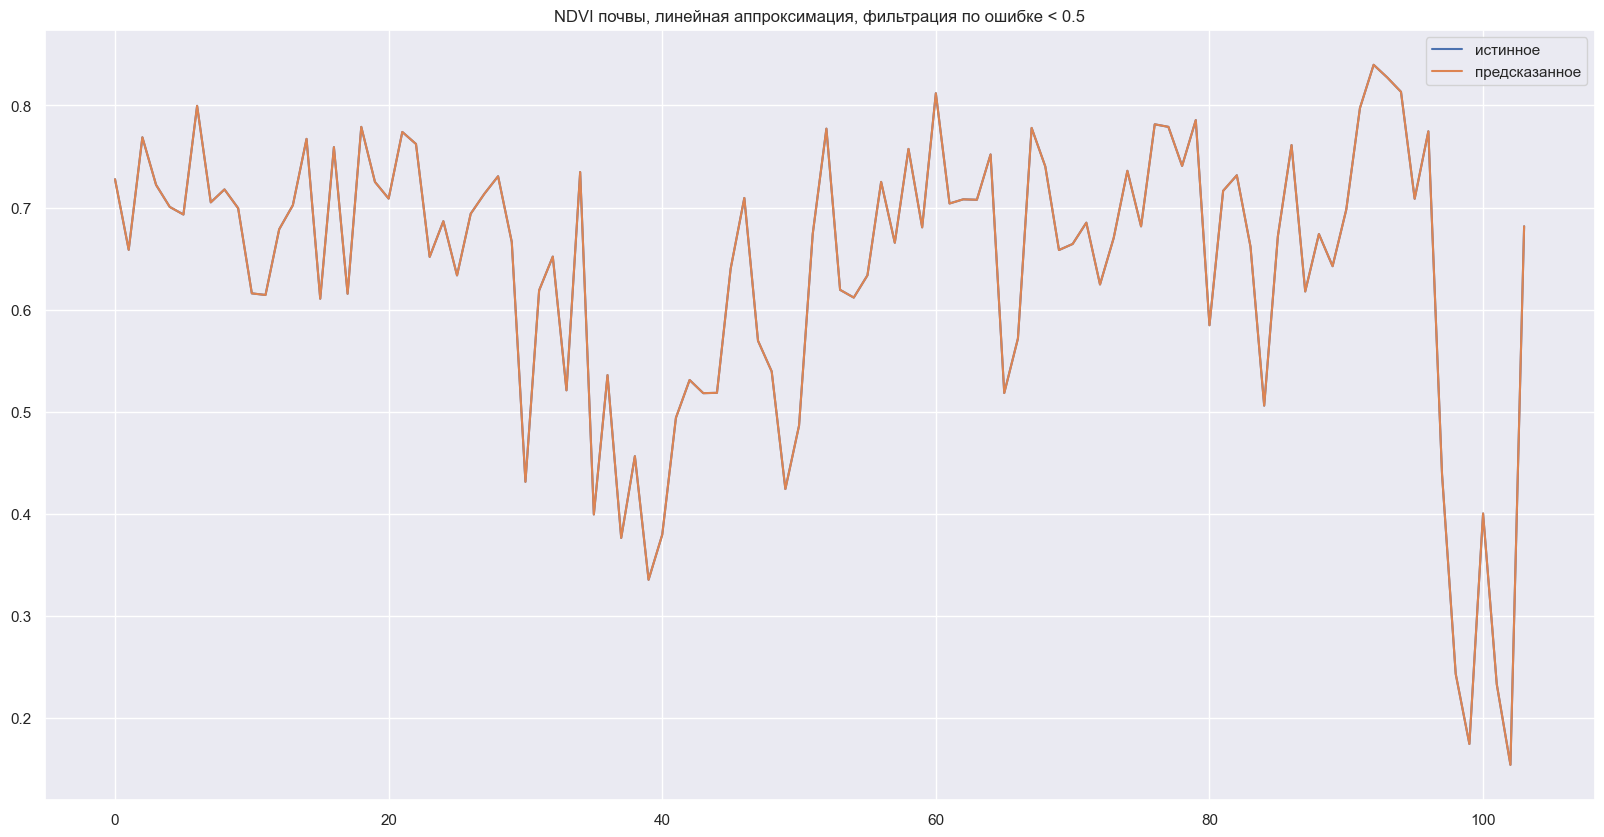

In [1290]:
MAX_ERR = 0.5

filtered_ids = []
filtered_data = []
filtered_NDVI = np.array([])


X=np.array(X)
Y=df['NDVI']


for x in range(0, len(df['NDVI'])):
    err = abs(real_NDVI[x] - predicted_NDVI[x])
 
    if err < MAX_ERR:
        filtered_ids.append(int(x))
        filtered_data.append(X[x])
        filtered_NDVI = np.append(filtered_NDVI, real_NDVI[x])

filtered_data = np.array(filtered_data)    
    
model = ExtraTreesRegressor()
model.fit(filtered_data, filtered_NDVI)

X=df[optimal_features]
Y=df['NDVI']

X_train, X_test, Y_train, Y_test  = train_test_split(X, Y, test_size = 0.20, shuffle = True)

r_sq = model.score(X_test, Y_test)
print("R2", r_sq)

predict = model.predict(filtered_data)

fig = plt.figure()
fig.set_figwidth(20)
fig.set_figheight(10)
plt.title(f'NDVI почвы, линейная аппроксимация, фильтрация по ошибке < { MAX_ERR }')

plt.plot(Y, label="истинное")
plt.plot(predict, label="предсказанное")

plt.legend()
plt.show()

На рисунке выше показаны графики значений параметра NDVI из исходных данных и предсказанные. Видно, что полученная модель неплохо справляется с задачей предсказания. 